# Simpsons Object Detection

This notebook is to be used as an addition to my blog on object detection and holds all the code used for the project.

Credit for the data goes to the original artists from the Simpsons, and some of the code is taken from the PyTorch Instance Segmentation Torchvision tutorial, in order to bootstrap the development.

## Imports and installation of dependencies

In [1]:
import torchvision
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import re
from PIL import Image
from google.colab import drive
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch

In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-oqp7y701
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-oqp7y701
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=421021 sha256=6c9800da7164f7e31bf790597686551ed6d248e7edf18d4c14b266c110a38ef4
  Stored in directory: /tmp/pip-ephem-wheel-cache-g8q0m2uf/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.

In [3]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 286132, done.
remote: Counting objects: 100% (7258/7258), done.
remote: Compressing objects: 100% (410/410), done.
remote: Total 286132 (delta 6864), reused 7197 (delta 6833), pack-reused 278874
Receiving objects: 100% (286132/286132), 572.39 MiB | 16.71 MiB/s, done.
Resolving deltas: 100% (261966/261966), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


## Exploring and Preparing Data

The data comes from Kaggle. Before running any models let's look at the data we have.

Lets mount the Google drive to load in data, read and manipulate the file paths and then try and create a bounding box using the x1, y1, x2 and y2 coordinates.

In [ ]:
drive.mount('Drive') 

In [5]:
directory_path = 'path'

In [ ]:
boxes = pd.read_csv(directory_path+'annotation.txt', header=None)
boxes.columns = ['path', 'x1', 'y1', 'x2', 'y2', 'name']
boxes.head()

Image reading code for making masks and resizing.

In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


def convert_file_path(path):
  path = directory_path + 'simpsons_dataset/' + re.search('([A-z]|\_)*\/pic_[0-9]*\.jpg', path).group(0)

  return path

In [ ]:
boxes['filepath'] = boxes.apply(lambda row: convert_file_path(row['path']), axis=1)
boxes.head()

In [ ]:
# read in image
for _, row in boxes.sample(2).iterrows():
  fig,ax = plt.subplots(1)

  im = read_image(row['filepath'])
  plt.imshow(im)
  ax.imshow(im)
  #make rectangular bounding box
  bb = patches.Rectangle(xy=(row['x1'],row['y1']),width=row['x2']-row['x1'],height=row['y2']-row['y1'],linewidth=1.2,edgecolor='r',facecolor='none')
  ax.add_patch(bb) #add bounding box to image
  plt.show()

Awesome! We have data, and the bounding boxes seem to be sensible! There is a brilliant guide on creating image masks at the link below which I have adapted for this project:

https://medium.com/towards-data-science/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc

In [7]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(cols)
    left_col = np.min(rows)
    bottom_row = np.max(cols)
    right_col = np.max(rows)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[1],x[2],x[3],x[4]])

def resize_image_bb(read_path,new_path,bb, mask_path):
    """Resize an image and its bounding box and write image to new path"""
    # read in an image using the cv function
    im = read_image(read_path)

    # resize the image
    im_resized = cv2.resize(im, (300, 300))
    
    # resize the mask
    Y_resized = cv2.resize(create_mask(bb, im), (300, 300))

    # write out to the new path
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    plt.imshow(im_resized)
    
    # return the new path and bb mask
    return new_path, mask_to_bb(Y_resized)

Loop to create new images and paths.

In [ ]:
new_paths = []
new_bbs = []

# for each row
for index, row in boxes.iterrows():
    # write images to the new path
    new_path = re.sub('\.jpg', '_processed.jpg', row['filepath'])
    mask_path = re.sub('\.jpg', '_mask.jpg', row['filepath'])

    # resize the image and the bounding box
    new_path, new_bb = resize_image_bb(row['filepath'], new_path,
                                       create_bb_array(row.values), mask_path)
    
    # store the new information
    new_paths.append(new_path)
    new_bbs.append(new_bb)

boxes['new_path'] = new_paths
boxes['new_bb'] = new_bbs
boxes.head()

In [ ]:
boxes.to_parquet(directory_path+'boxes.parquet')

In [8]:
# read in the info from parquet (so that code can be run from this cell)
boxes = pd.read_parquet(directory_path+'boxes.parquet')
boxes['error'] = boxes.apply(lambda row: min([(row['new_bb'][2] - row['new_bb'][0]), (row['new_bb'][3] - row['new_bb'][1])]), axis=1)
boxes = boxes[boxes['error']>0].copy()
boxes.head()

,path,x1,y1,x2,y2,name,filepath,class,new_path,new_bb,error
1,./characters/abraham_grampa_simpson/pic_0001.jpg,80,31,337,354,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,10,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[48.0, 25.0, 203.0, 288.0]",155.0
2,./characters/abraham_grampa_simpson/pic_0002.jpg,128,48,285,407,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,10,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[133.0, 34.0, 296.0, 293.0]",163.0
3,./characters/abraham_grampa_simpson/pic_0003.jpg,72,126,158,275,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,10,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[74.0, 87.0, 164.0, 190.0]",90.0
4,./characters/abraham_grampa_simpson/pic_0004.jpg,123,61,294,416,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,10,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[115.0, 38.0, 275.0, 259.0]",160.0
5,./characters/abraham_grampa_simpson/pic_0005.jpg,115,18,498,413,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,10,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[60.0, 13.0, 259.0, 297.0]",199.0


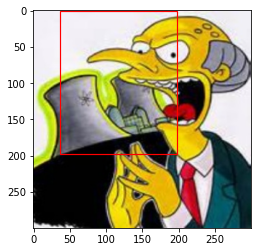

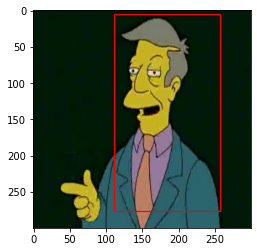

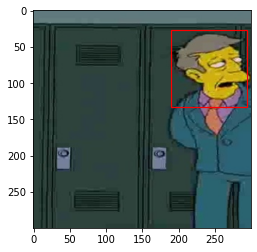

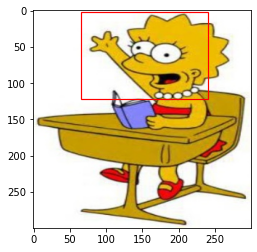

In [9]:
for _, row in boxes.sample(4).iterrows():
  fig,ax = plt.subplots(1)

  im = read_image(row['new_path'])
  plt.imshow(im)

  ax.imshow(im)

  #make rectangular bounding box
  bb = patches.Rectangle(xy=(row['new_bb'][0],row['new_bb'][1]),width=row['new_bb'][2]-row['new_bb'][0],height=row['new_bb'][3]-row['new_bb'][1],linewidth=1.2,edgecolor='r',facecolor='none')
  ax.add_patch(bb) #add bounding box to image
  plt.show()

Next is adding the labels to the dataframe

In [10]:
unique_chars = list(set(boxes['name']))
labels = {unique_chars[i]: i+1 for i in range(0, len(unique_chars))}
boxes['class'] = boxes.apply(lambda row: labels.get(row['name']), axis=1)
boxes.head()

,path,x1,y1,x2,y2,name,filepath,class,new_path,new_bb,error
1,./characters/abraham_grampa_simpson/pic_0001.jpg,80,31,337,354,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,12,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[48.0, 25.0, 203.0, 288.0]",155.0
2,./characters/abraham_grampa_simpson/pic_0002.jpg,128,48,285,407,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,12,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[133.0, 34.0, 296.0, 293.0]",163.0
3,./characters/abraham_grampa_simpson/pic_0003.jpg,72,126,158,275,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,12,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[74.0, 87.0, 164.0, 190.0]",90.0
4,./characters/abraham_grampa_simpson/pic_0004.jpg,123,61,294,416,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,12,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[115.0, 38.0, 275.0, 259.0]",160.0
5,./characters/abraham_grampa_simpson/pic_0005.jpg,115,18,498,413,abraham_grampa_simpson,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,12,drive/MyDrive/imgs/simpsons_dataset/abraham_gr...,"[60.0, 13.0, 259.0, 297.0]",199.0


And assembling the data into a PyTorch dataset

In [11]:
class SimpsonsDataset(torch.utils.data.Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms

    def __getitem__(self, idx):

        # record
        record = self.data.iloc[idx]

        # load images
        img_path = record['new_path']
        img = Image.open(img_path).convert("RGB")

        # get bounding box coordinates for each mask
        boxes = record['new_bb']

        boxes = torch.as_tensor((boxes,), dtype=torch.float32)

        # there is only one class
        labels = torch.as_tensor((record['class'],), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area


        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.data)

In [12]:
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

That's the dataset constructed, let's start assembling the model

# Model Build

The model is built using PyTorch Faster R-CNN. Most of the training code below comes from the PyTorch documentation with some tweaks for the data to fit

In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = len(unique_chars)+1  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [14]:
from sklearn.model_selection import train_test_split

# split data into testing and train
X_train, X_test, y_train, y_test = train_test_split(boxes[[col for col in boxes.columns if col != 'class']], boxes['class'], test_size=0.2)

X_train['class'] = y_train
X_test['class'] = y_test
train = X_train.reset_index()
test = X_test.reset_index()

In [ ]:
import utils

# load train and test data 
dataset = SimpsonsDataset(train, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)

test = SimpsonsDataset(test, get_transform(train=False))
data_loader_test = torch.utils.data.DataLoader(
    test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# CHECK MODEL WILL WORK
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [16]:
# to use GPU in Colab
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = num_classes

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from torch.optim.lr_scheduler import StepLR
from engine import train_one_epoch, evaluate

num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()

In [18]:
torch.save(model, 'drive/MyDrive/imgs/model.bin')
torch.save(test, 'drive/MyDrive/imgs/test.bin')
torch.save(train, 'drive/MyDrive/imgs/train.bin')

## Model Evaluation

The model is evaluated using IoU or Intersection over Union and then as a classifier is evaluated via a confusion matrix

<ipython-input-11-401572160f06>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  boxes = torch.as_tensor((boxes,), dtype=torch.float32)


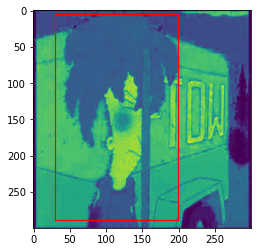

In [20]:
img, _ = test[10]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
    
box = prediction[0]['boxes'][0].cpu()

fig,ax = plt.subplots(1)

img = test[10][0][0]

ax.imshow(img)

#make rectangular bounding box
bb = patches.Rectangle(xy=(box[0],box[1]),width=box[2]-box[0],height=box[3]-box[1],linewidth=1.2,edgecolor='r',facecolor='none')
ax.add_patch(bb) #add bounding box to image
plt.show()

In [21]:
# pick each image from the test set
predictions = []
print(len(test))
for t in range(len(test)):
  img, _ = test[t]

  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])
      predictions.append([_, prediction])

1342


In [22]:
records = []

for c in predictions:
  # access variables from the correct data structure and convert back from tensors
  y_label = int(c[0]['labels'][0].item())
  y_box = [i.item() for i in c[0]['boxes'][0].cpu()]

  # if no prediction is made add None
  if len(c[1][0]['labels']) == 0:
    y_hat_label = None
    y_hat_box = None
    score = None

  else:
    y_hat_label = int(c[1][0]['labels'][0].item())
    y_hat_box = [i.item() for i in c[1][0]['boxes'][0].cpu()]
    score = c[1][0]['scores'][0].item()

  record = {'y_label': y_label, 'y_box': y_box, 'y_hat_label': y_hat_label, 'y_hat_box': y_hat_box, 'score': score}

  records.append(record)

pred_true = pd.DataFrame(records)
pred_true.to_parquet(directory_path+'predvstrue.parquet')
pred_true.head()

,y_label,y_box,y_hat_label,y_hat_box,score
0,18,"[106.0, 31.0, 271.0, 219.0]",18,"[94.48760986328125, 27.351791381835938, 278.74...",0.988605
1,13,"[59.0, 1.0, 195.0, 294.0]",13,"[75.38953399658203, 1.4321250915527344, 201.59...",0.995647
2,4,"[7.0, 14.0, 207.0, 251.0]",4,"[88.88648986816406, 27.560571670532227, 194.06...",0.866717
3,8,"[148.0, 4.0, 245.0, 222.0]",8,"[148.4281768798828, 14.114072799682617, 248.53...",0.975407
4,4,"[52.0, 30.0, 104.0, 140.0]",4,"[41.547523498535156, 34.06971740722656, 137.01...",0.191365


In [23]:
df = pd.read_parquet(directory_path + 'predvstrue.parquet')
df.head()

,y_label,y_box,y_hat_label,y_hat_box,score
0,18,"[106.0, 31.0, 271.0, 219.0]",18,"[94.48760986328125, 27.351791381835938, 278.74...",0.988605
1,13,"[59.0, 1.0, 195.0, 294.0]",13,"[75.38953399658203, 1.4321250915527344, 201.59...",0.995647
2,4,"[7.0, 14.0, 207.0, 251.0]",4,"[88.88648986816406, 27.560571670532227, 194.06...",0.866717
3,8,"[148.0, 4.0, 245.0, 222.0]",8,"[148.4281768798828, 14.114072799682617, 248.53...",0.975407
4,4,"[52.0, 30.0, 104.0, 140.0]",4,"[41.547523498535156, 34.06971740722656, 137.01...",0.191365


In [24]:
# calculate the intersection
def calculate_intersection(pred, true):
  if pred is None:
    return 0
  else:
    # find diff x and y then multiply for area using min/max method
    dx = min(pred[2], true[2]) - max(pred[0], true[0])
    dy = min(pred[3], true[3]) - max(pred[1], true[1])
    if (dx>=0) and (dy>=0):
      return dx*dy
    else:
      return 0

df['overlap'] = df.apply(lambda row: calculate_intersection(row['y_hat_box'], row['y_box']), axis=1)
df.head()

,y_label,y_box,y_hat_label,y_hat_box,score,overlap
0,18,"[106.0, 31.0, 271.0, 219.0]",18,"[94.48760986328125, 27.351791381835938, 278.74...",0.988605,28925.298615
1,13,"[59.0, 1.0, 195.0, 294.0]",13,"[75.38953399658203, 1.4321250915527344, 201.59...",0.995647,32093.582252
2,4,"[7.0, 14.0, 207.0, 251.0]",4,"[88.88648986816406, 27.560571670532227, 194.06...",0.866717,11316.238776
3,8,"[148.0, 4.0, 245.0, 222.0]",8,"[148.4281768798828, 14.114072799682617, 248.53...",0.975407,15335.439477
4,4,"[52.0, 30.0, 104.0, 140.0]",4,"[41.547523498535156, 34.06971740722656, 137.01...",0.191365,5508.374695


In [25]:
def calculate_union(pred, true, intersection):
  original_area = (true[3]-true[1]) * (true[2] - true[1])
  pred_area = (pred[3]-pred[1]) * (pred[2] - pred[1]) if pred is not None else 0
  return original_area + pred_area - intersection

df['union'] = df.apply(lambda row: calculate_union(row['y_hat_box'], row['y_box'],
                                                   row['overlap']), axis=1)

df['iou'] = df.apply(lambda row: row['overlap']/row['union'], axis=1)
df['Evaluation'] = df.apply(lambda row: 'True Positive' if row['iou']>=0.4 else 'False Positive', axis=1)

In [26]:
import plotly.express as px

vis_data = df.groupby('Evaluation').size().reset_index().rename(columns={0: 'Number of predictions'})
px.bar(vis_data, 'Evaluation', 'Number of predictions', template='seaborn')

Analysis of the charts is given in the blog post 😃

In [27]:
df['Character Evaluation'] = df.apply(lambda row: 'Matched' if row['y_label']==row['y_hat_label'] else 'Unmatched', axis=1)
vis_data = df.groupby('Character Evaluation').size().reset_index().rename(columns={0: 'Number of predictions'})
px.bar(vis_data, 'Character Evaluation', 'Number of predictions', template='seaborn')

In [28]:
from sklearn.metrics import confusion_matrix
df['y_hat_label'] = df.apply(lambda row: 19 if pd.isna(row['y_hat_label']) else row['y_hat_label'], axis=1)
matrix = confusion_matrix(df['y_label'], df['y_hat_label'])
map = px.imshow(matrix, template='seaborn')
map.update_xaxes(title='True')
map.update_yaxes(title='Prediction')

A test image with multiple characters is also added below for fun!

In [40]:
from torchvision import transforms

model = torch.load('drive/MyDrive/imgs/model.bin', map_location=torch.device('cpu'))
img = Image.open(directory_path+'SimpsonFamily.jpeg')
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)
model.eval()
with torch.no_grad():
    prediction = model([img])

In [41]:
labels = pd.read_parquet(directory_path+'boxes.parquet')
labels = labels.groupby(['name', 'class']).sum().reset_index()
lookup = {r['class']: r['name'] for _,r in labels.iterrows()}
lookup

{10: 'abraham_grampa_simpson',
 1: 'apu_nahasapeemapetilon',
 13: 'bart_simpson',
 12: 'charles_montgomery_burns',
 6: 'chief_wiggum',
 2: 'comic_book_guy',
 7: 'edna_krabappel',
 4: 'homer_simpson',
 11: 'kent_brockman',
 18: 'krusty_the_clown',
 16: 'lisa_simpson',
 17: 'marge_simpson',
 15: 'milhouse_van_houten',
 14: 'moe_szyslak',
 3: 'ned_flanders',
 8: 'nelson_muntz',
 5: 'principal_skinner',
 9: 'sideshow_bob'}

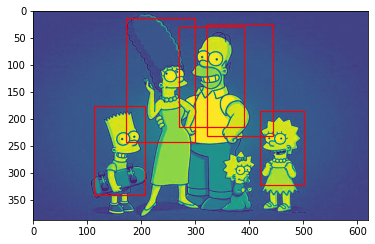

In [42]:
fig,ax = plt.subplots(1)


ax.imshow(img[0])

#make rectangular bounding box
for i in range(0,5):
  box = prediction[0]['boxes'][i].cpu()

  bb = patches.Rectangle(xy=(box[0],box[1]),width=box[2]-box[0],height=box[3]-box[1],linewidth=1.2,edgecolor='r',facecolor='none')
  ax.add_patch(bb) #add bounding box to image
plt.show()